# Variogram Point Cloud

## Table of Contents:

1. Read point data,
2. Create variogram point cloud,
3. Detect and remove outliers.
4. Calculate experimental semivariance from point cloud.

## Level: Basic

## Changelog

| Date       | Change description                                                                                                                                                     | Author                     |
|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| 2022-10-21 | Updated to the version 0.3.4 | @SimonMolinsky |
| 2022-10-17 | Corrected data selection, now tutorial will run faster | @SimonMolinsky |
| 2022-08-17 | Updated to the version 0.3.0                                                                                                                                           | @SimonMolinsky             |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                                | @SimonMolinsky             |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` function to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-08-22 | Refactored the Outlier Removal algorithm - quantile based algorithm                                                                                                    | @SimonMolinsky             |
| 2021-08-10 | Refactored the Outlier Removal algorithm                                                                                                                               | @SimonMolinsky             |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                                                                              | @SimonMolinsky             |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                                                                    | @SimonMolinsky             |

## Introduction

We will learn how to read and prepare data for semivariogram modeling, manually find the best step size between lags, and detect outliers in our data.

Variogram Point Cloud analysis is an additional, essential data preparation step that may save you a lot of headaches with a more sophisticated analysis. You should learn about Variogram Point Cloud analysis before you move on to the semivariogram estimation and semivariogram fitting operations.

We use:

- for points 1 and 2: DEM data stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`,
- for points 3 and 4: Breast cancer rates data is stored in the shapefile in folder `samples/regularization/cancer_data.gpkg`.

## Import packages

In [1]:
import numpy as np

from pyinterpolate import Blocks, read_txt, calc_point_to_point_distance, VariogramCloud
from pyinterpolate.variogram.empirical.experimental_variogram import calculate_semivariance

## 1) Read point data

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

In [3]:
sample_size = int(0.05 * len(dem))
indices = np.random.choice(len(dem), sample_size, replace=False)
dem = dem[indices]

# Look into a first few lines of data

dem[:10, :]

array([[2.53770053e+05, 5.52209018e+05, 7.53570328e+01],
       [2.45740762e+05, 5.47410367e+05, 3.13298454e+01],
       [2.50076035e+05, 5.46908336e+05, 2.43907852e+01],
       [2.38115549e+05, 5.45947191e+05, 8.59198914e+01],
       [2.54457974e+05, 5.37781730e+05, 3.21219940e+01],
       [2.50403316e+05, 5.36073516e+05, 3.22589760e+01],
       [2.40676186e+05, 5.42764493e+05, 1.74453812e+01],
       [2.50346460e+05, 5.40712676e+05, 2.18128986e+01],
       [2.45648110e+05, 5.37449876e+05, 1.89279823e+01],
       [2.38000746e+05, 5.44315336e+05, 2.43942070e+01]])

## 2) Set proper lag size with variogram cloud histogram

We will generate the Variogram Point Cloud. We calculate it for 16 lags and test different cloud variogram visualization methods.

In [4]:
# Create analysis parameters

# Check max distance between points
distances = calc_point_to_point_distance(dem[:, :-1])
maximum_range = np.max(distances) / 2

number_of_lags = 16
step_size = maximum_range / number_of_lags

vc = VariogramCloud(input_array=dem, step_size=step_size, max_range=maximum_range)

Check how many points are grouped for each lag:

In [5]:
for idx, _lag in enumerate(vc.lags):
    print(f'Lag {_lag} has {vc.points_per_lag[idx]} point pairs.')

Lag 901.2821082093058 has 724 point pairs.
Lag 1802.5642164186115 has 2120 point pairs.
Lag 2703.846324627917 has 3082 point pairs.
Lag 3605.128432837223 has 4218 point pairs.
Lag 4506.410541046529 has 5248 point pairs.
Lag 5407.692649255835 has 5960 point pairs.
Lag 6308.97475746514 has 6388 point pairs.
Lag 7210.256865674446 has 6802 point pairs.
Lag 8111.538973883752 has 7236 point pairs.
Lag 9012.821082093058 has 7658 point pairs.
Lag 9914.103190302363 has 7704 point pairs.
Lag 10815.385298511668 has 7460 point pairs.
Lag 11716.667406720973 has 7198 point pairs.
Lag 12617.94951493028 has 7084 point pairs.
Lag 13519.231623139585 has 6364 point pairs.


As we see, there are a lot of points per lag! Data is probably messy, but to be sure, we must check its distribution. What are those **points per lag**? They are a set of semivariances between all point pairs within a specific lag. This information helps us to understand if there are any undersampled ranges. Then, we can change `step_size` accordingly (to avoid a situation where one lag has the order of magnitude less/more point pairs than the other).

We know points density per lag, great. Now we can analyze semivariances distribution per lag. The `VariogramCloud` class has three plot types we use for analysis:

1. *Scatter plot*. It shows the general dispersion of semivariances.
2. *Box plot* - an excellent tool for outliers detection. It shows dispersion and quartiles of semivariances per lag. We can check distribution differences and their deviation from normality or skewness.
3. *Violin plot*. It is a box plot on steroids. We can read all information like from the box plot, plus we see kernel density plots.

Let's plot them all. The first is a scatter plot. It can take a while (we have thousands of point pairs), so now is a good time to prepare a beverage.

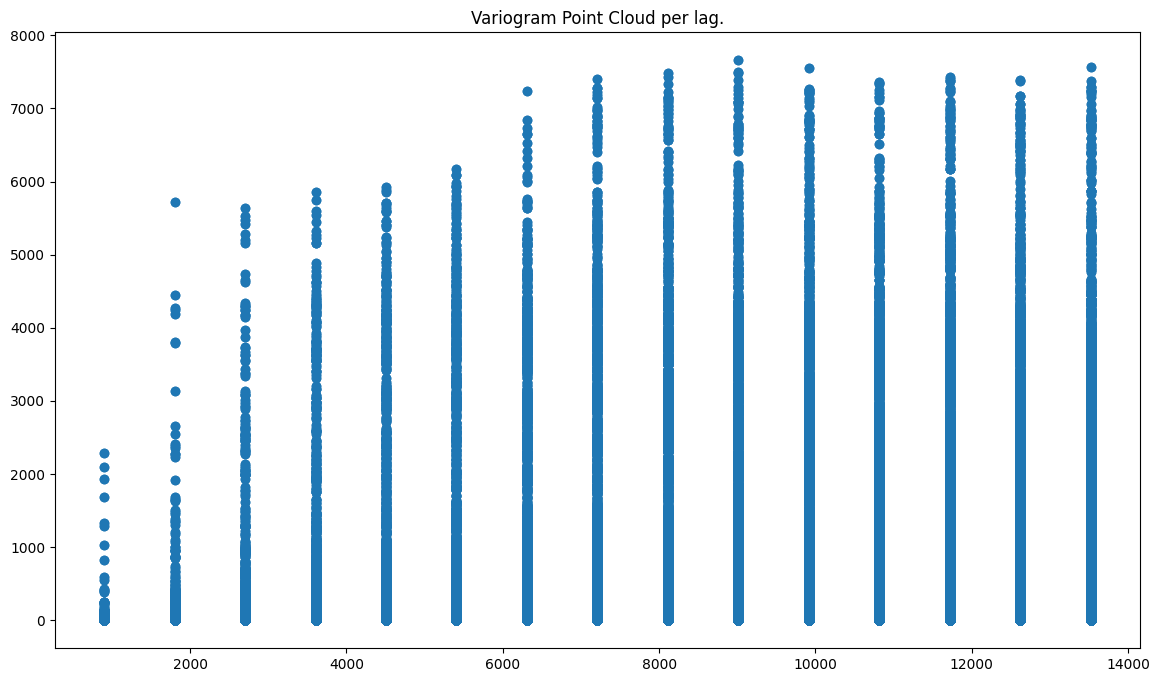

In [6]:
vc.plot('scatter')

The output per lag is dense, and we cannot distinguish a single value. But, we can follow a general trend and see maxima on the plot. We can make it better if we use a box plot instead:

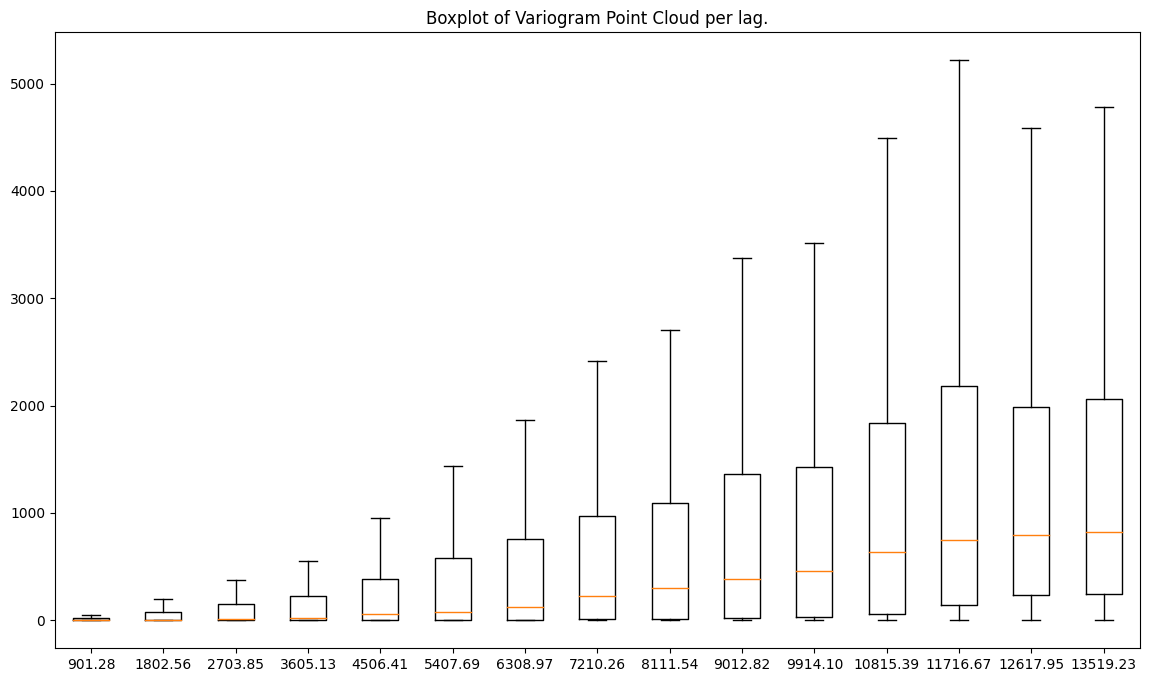

In [7]:
vc.plot('box')

The orange line in the middle of each box represents the median (50%) value per lag. The trend is more visible if we look into it. What else can be seen here?

1. Dispersion of values is greater with a distance, but at the same time, median and the **3rd quartile** of semivariance values are rising (**3rd quartile** is plotted as a horizontal line on a top of a box.
2. The maximum value rises with a distance (it is a horizontal line on a top of a whisker).
3. Data is skewed towards lower values of semivariance. Why? Because the median is closer to the bottom of a box than the center or the top.
4. The **1st quartile** (25% of the lowest values) is higher for distant lags.

We could stop our analysis here, but there is a better option to analyze data distribution than a box plot. We can use a violin plot:

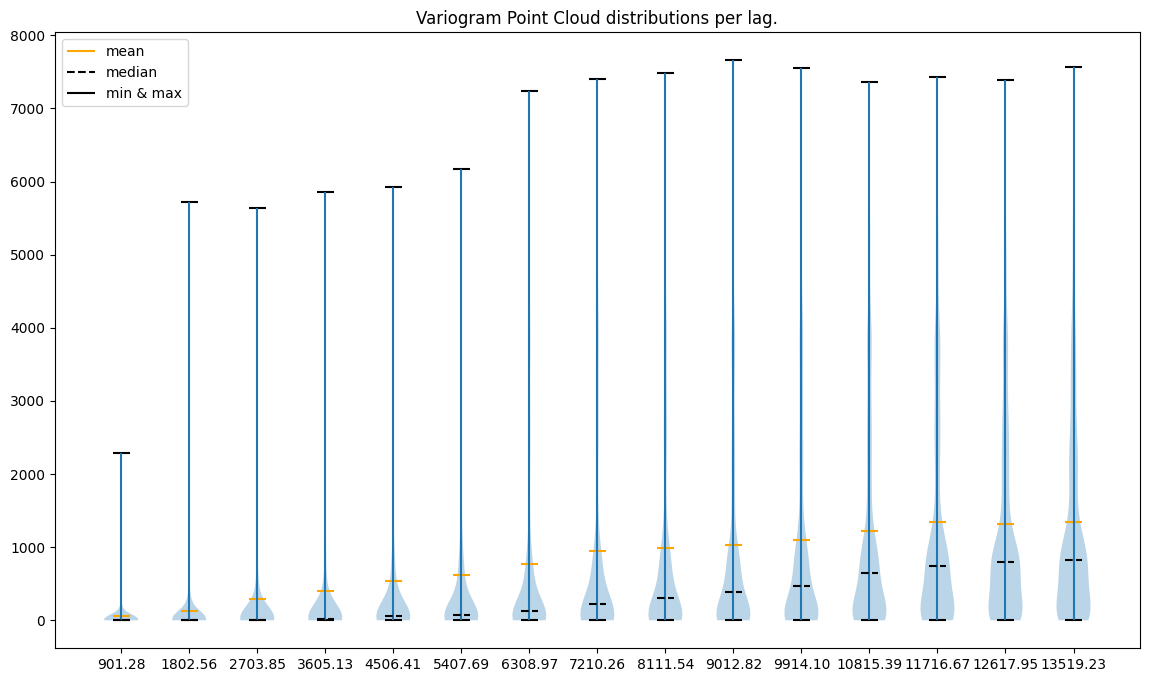

In [8]:
vc.plot('violin')

The violin plot supports our earlier assumptions, but we can learn more from it. For distant lags, a distribution starts to be multimodal. We see one mode around very low values of semivariance and another mode close to the 1st quartile. Multimodality may affect our outcomes, and maybe it tells us that there is more than one level of spatial dependency?

There is still the elephant in the room. Our data is pulled up with outliers. Do you see long whiskers on the top of every distribution? We can let them be, but maybe the better idea is to clean it before we start Kriging? In the next paragraph, we will detect and remove outliers from a block dataset.

## 3) Detect and remove outliers

With the idea of how the Variogram Point Cloud works, we can detect and "remove" outliers from our dataset. In this part of the tutorial, we use another dataset. It represents the breast cancer rates in counties of the Northeastern part of the U.S. Each county will be transformed into its centroid. Those centroids are not evenly spaced, and we expect the dataset may be modeled incorrectly for several steps.

In [9]:
# Read and prepare data

DATASET = 'samples/regularization/cancer_data.gpkg'
POLYGON_LAYER = 'areas'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'
MAX_RANGE = 400000
STEP_SIZE = 40000

AREAL_INPUT = Blocks()
AREAL_INPUT.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

AREAL_INPUT.data.head()

,FIPS,geometry,rate,centroid_x,centroid_y
0,25019,"MULTIPOLYGON (((2115688.816 556471.240, 211569...",192.2,2.132630e+06,557971.155949
1,36121,"POLYGON ((1419423.430 564830.379, 1419729.721 ...",166.8,1.442153e+06,550673.935704
2,33001,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",157.4,1.958207e+06,766008.383446
3,25007,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",156.7,2.082188e+06,556830.822367
4,25001,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",155.3,2.100747e+06,600235.845891


In [10]:
areal_centroids = AREAL_INPUT.data[[AREAL_INPUT.cx, AREAL_INPUT.cy, AREAL_INPUT.value_column_name]].values

In [11]:
# Create analysis parameters

# Check max distance between points

distances = calc_point_to_point_distance(areal_centroids[:, :-1])
maximum_range = np.max(distances) / 2

number_of_lags = 8
step_size = maximum_range / number_of_lags

vc = VariogramCloud(input_array=areal_centroids, step_size=step_size, max_range=maximum_range)

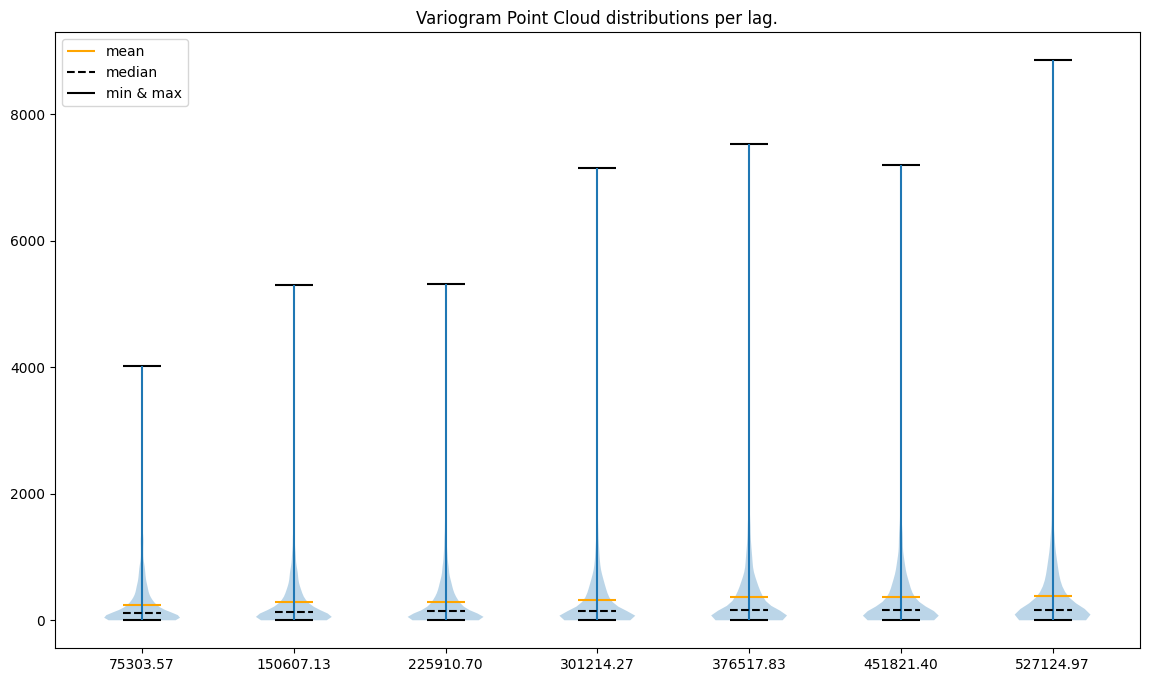

In [12]:
vc.plot('violin')

In [13]:
for idx, _lag in enumerate(vc.lags):
    print(f'Lag {_lag} has {vc.points_per_lag[idx]} point pairs.')

Lag 75303.56650292415 has 1936 point pairs.
Lag 150607.1330058483 has 4740 point pairs.
Lag 225910.69950877246 has 6532 point pairs.
Lag 301214.2660116966 has 7254 point pairs.
Lag 376517.83251462074 has 7066 point pairs.
Lag 451821.39901754487 has 5904 point pairs.
Lag 527124.9655204691 has 4494 point pairs.


Our data is skewed towards large values. Thus, we will remove outliers from the upper part of the dataset. We will use the interquartile range algorithm. It detects outliers as all points below the first quartile of a data plus `m` (positive or zero `float`) standard deviations and all points above the 3rd quartile plus `n` (positive or zero `float`) standard deviations. The important thing is that the absolute values of `m` and `n` can be different. We should fit those values to the distribution, and its skewness.

The class `VariogramCloud` has internal method `.remove_outliers()`. With parameter `inplace` set to `True` we can overwrite the variogram point cloud, but if we set it to `False` and it will return a new `VariogramCloud` object with a cleaned variogram point cloud. Other parameters:

* `method`: is a string with a method of removing outliers. We have two methods, one based on **z-scores** and the **interquartile range** method. Both have upper and lower bounds. The Z-score method is invoked with `method='zscore'`, and arguments for this function are `z_lower_limit` and `z_upper_limit` (number of standard deviations from the mean down and up, or negative and positive).
* `iqr_lower_limit`: how many standard deviations should be subtracted from the first quartile to set a limit of valid values,
* `iqr_upper_limit`: how many standard deviations should be added to the 3rd quartile to set a limit of valid values.

The values we will get will be within a limits:

$$q1 - (m * std) < V < q3 + (n * std),$$

where:
* $q1$: 1st quartile,
* $q3$: 3rd quartile,
* $std$: standard deviation,
* $m$: real value greater than 0,
* $n$: real value greater than 0,
* $V$: the cleaned array.

In [14]:
cvc = vc.remove_outliers(method='iqr', iqr_lower_limit=3, iqr_upper_limit=2, inplace=False)

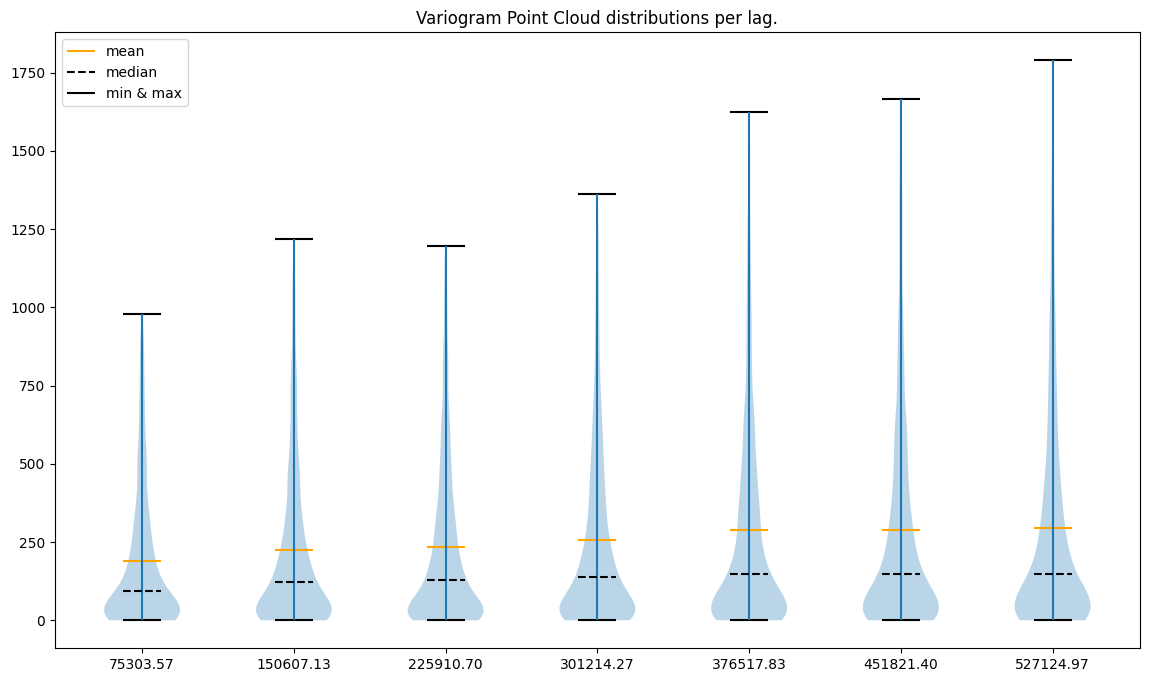

In [15]:
cvc.plot('violin')

When we compare both figures - before and after data cleaning - we see that the y-axis of the second plot is 6-7 times smaller than the y-axis of the first plot! We've cleaned our data from the extreme values.

## 4) Calculate experimental semivariogram from point cloud

The last but not least property of the experimental variogram point cloud is that we may calculate semivariogram directly from it. The method for it is `.calculate_experimental_variogram()`. Let's compare outputs from two algorithms.

In [16]:
exp_variogram_from_points = calculate_semivariance(areal_centroids, step_size=step_size, max_range=maximum_range)
exp_variogram_from_p_cloud = vc.calculate_experimental_variogram()

In [17]:
np.array_equal(exp_variogram_from_points, exp_variogram_from_p_cloud)

True

Both semivariograms are the same, but methods to obtain these were different.

---